## Topic Modeling: COVID-19 Early Social Concerns 

This notebook uses google colab, it is important to change the path of the data before run it.

In [1]:
# Load drive for colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install bitermplus
!pip install tmplot
!pip install corextopic

# Prepare packages
import pickle
import bitermplus as btm
import tmplot as tmp
import pandas as pd
# Import the wordcloud library
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('wordnet')
import gensim.corpora as corpora
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.corpus import stopwords
import re
import string
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
import numpy as np
# https://predictivehacks.com/topic-modelling-with-nmf-in-python/
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline

stemmer = SnowballStemmer("english", ignore_stopwords=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# # Used to store the model and load model instead run it everytime
# import pickle
# def save(data, name):
#     path = f"/content/drive/MyDrive/2209/Midterm/model/{name}.pickle"
#     with open(path, "wb") as file:   #Pickling
#         pickle.dump(data, file)

# def load(name):
#     path = f"/content/drive/MyDrive/2209/Midterm/model/{name}.pickle"
#     with open(path, "rb") as file:   #Pickling
#         return pickle.load(file)

### Data Preprocessing

In [4]:
# https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification?resource=download&select=Corona_NLP_train.csv
df = pd.read_csv("/content/drive/MyDrive/2209/Midterm/data/Corona_NLP_train.csv",encoding='latin-1').dropna()


In [5]:
# Find the data with location that tweets over 50
# df = df.groupby("Location").filter(lambda x : len(x)>50)
# df["Location"].value_counts()

# Get month from the date
df["datetime"]=pd.to_datetime(df['TweetAt'])
df.sort_values("datetime", inplace = True)
df["month"]=df["datetime"].dt.month
df.reset_index(inplace =True, drop=True)
df

UserName  ScreenName                        Location     TweetAt  \
0         29779       74731            Brooklyn / the world  01-04-2020   
1         29349       74301   Ginninderra Creek Canberra Oz  01-04-2020   
2         29350       74302                    Brooklyn, NY  01-04-2020   
3         29351       74303                          London  01-04-2020   
4         29352       74304                  las cruces,nm   01-04-2020   
...         ...         ...                             ...         ...   
32562     42982       87934       Adelaide, South Australia  12-04-2020   
32563     42979       87931                Karachi Pakistan  12-04-2020   
32564     42978       87930                         NY & NJ  12-04-2020   
32565     42975       87927                Bedford, England  12-04-2020   
32566     42847       87799                   Kenya??AFRICA  12-04-2020   

                                           OriginalTweet           Sentiment  \
0      World risks food crisis in wake of coronavirus...  Extremely Negative   
1      The Canberra Relief Network CRN is the ACT Gov...            Positive   
2      I worked at a nightclub. I lived shift to shif...  Extremely Positive   
3      Think all the 'extra' supermarkets need to clo...            Negative   
4      Lowe's closes Harper Woods store to customers ...            Positive   
...                                                  ...                 ...   
32562  Gratitunes is a consumer-generated music platf...  Extremely Positive   
32563  @RamzanChhipa Thanks @RamzanChhipa \r\r\n\r\r\...            Positive   
32564  "Yearly Passover Food Distribution" outdoor wi...            Positive   
32565  Coronavirus can linger in air for a long time,...            Positive   
32566  OPEC has agreed to Cut Oil Production by 9.7 M...            Positive   

        datetime  month  
0     2020-01-04      1  
1     2020-01-04      1  
2     2020-01-04      1  
3     2020-01-04      1  
4     2020-01-04      1  
...          ...    ...  
32562 2020-12-04     12  
32563 2020-12-04     12  
32564 2020-12-04     12  
32565 2020-12-04     12  
32566 2020-12-04     12  

[32567 rows x 8 columns]

In [6]:
df["OriginalTweet"][:10]

0    World risks food crisis in wake of coronavirus...
1    The Canberra Relief Network CRN is the ACT Gov...
2    I worked at a nightclub. I lived shift to shif...
3    Think all the 'extra' supermarkets need to clo...
4    Lowe's closes Harper Woods store to customers ...
5    Beware of COVID 19 related scams involving che...
6    As continues its spread oil prices have tanked...
7    Shop alone have a plan and wash your hands her...
8     #TrumpPressConference never seen like this be...
9    Independent farmers are getting sidelined in f...
Name: OriginalTweet, dtype: object

#### Text Data Proprocessing

Get the hashtag for each data

In [7]:
df["hashtag"] = df["OriginalTweet"].apply(lambda x: re.findall(r"#(\w+)", x))

In [8]:
# Load the regular expression library
import re

# Leared from the notebook https://github.com/shionguha/inf2209-humancentredtopicmodels-fa22/blob/main/notebooks/topicmodels.ipynb
# Convert the titles to lowercase
df['text_processed'] = df['OriginalTweet'].map(lambda x: x.lower())
# Remove punctuation
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('[,\.!?]', '', x))

df['text_processed'] = df['text_processed'].map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('\w*\d\w*', ' ', x))
df['text_processed'] = df['text_processed'].map(lambda x: re.sub('�', ' ', x))

# Replace special character for our dataset
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(r'\r\n', '', x))
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(r'\r', '', x))

In [9]:
# Set stop words
stop_words = stopwords.words('english')
stop_words.extend(["https","tco", "amp", "coronavirus", "covid"])

In [10]:
df['text_processed']

0        world risks food crisis in wake of coronavirus...
1        the canberra relief network crn is the act gov...
2        i worked at a nightclub i lived shift to shift...
3        think all the  extra  supermarkets need to clo...
4        lowe s closes harper woods store to customers ...
                               ...                        
32562    gratitunes is a consumer generated music platf...
32563     ramzanchhipa thanks  ramzanchhipa  handgloves...
32564     yearly passover food distribution  outdoor wi...
32565    coronavirus can linger in air for a long time ...
32566    opec has agreed to cut oil production by   mil...
Name: text_processed, Length: 32567, dtype: object

In [11]:
# Display wordcloud
def display_wordcloud(df, maxWords = 100, stop_words = None, title = ""):
    long_string = ','.join(list(df['text_processed'].values))

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", 
                        max_words=maxWords, 
                        contour_width=3, 
                        stopwords = stop_words,
                        contour_color='steelblue')

    # Generate a word cloud
    wordcloud.generate(long_string)

    plt.figure(figsize=(10,7))
    if title == "":
        plt.title(f"Top {maxWords} frequent words",fontsize=30)
    else:
        plt.title(f"Top {maxWords} frequent words - {title}",fontsize=30)
    plt.xlabel("")
    plt.ylabel("")
    plt.imshow(wordcloud,interpolation='bilinear')
    # Visualize the word cloud
    # return wordcloud.to_image()

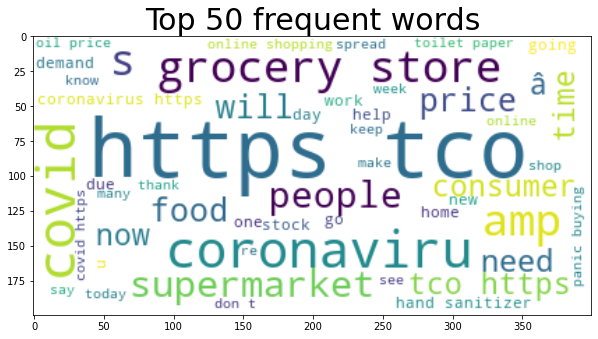

In [12]:
display_wordcloud(df,50)

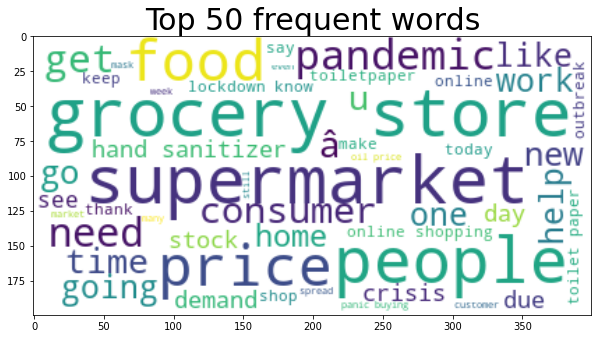

In [13]:
display_wordcloud(df,50, stop_words)

In [14]:
# Remove the stop words from the text
def remove_stopwords(texts, stop_words = stop_words):
    return [i for i in texts if i not in stop_words]
# https://elibooklover.github.io/Tutorials/Python/topicmodelingLDA/
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    nlp = spacy.load("en_core_web_sm")
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
    
# Get data in words for each tweet
def get_data_words(df):

    data = df["text_processed"].values.tolist()

    # Get a list of text for each tweet
    data_words = df["text_processed"].apply(lambda text : word_tokenize(text))
    # Remove stop words
    data_words = data_words.apply(lambda text : remove_stopwords(text)).tolist()
    # Remove stem
    data_words = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    return data_words

In [15]:
data_words = get_data_words(df)

In [16]:
# save(data_words, "data_words")
# data_words=load("data_words")

### Models

#### LDA

In [17]:
# Preprocess data for LDA
def preprocess_LDA(data_words):

    # Create Dictionary
    id2word = corpora.Dictionary(data_words)

    # Create Corpus
    texts = data_words# Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    return id2word, data_words, corpus

# Apply the LDA model
def apply_LDA(data_words, min_topics = 2, max_topics=5):

    id2word, data_words, corpus = preprocess_LDA(data_words)
    
    # Apply the LDA model
    perplexity_list = dict()
    coherence_list = dict()
    lda_models_list = dict()

    for num_topics in range(min_topics,max_topics+1):
        # Build LDA model
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state = 5)

        # https://radimrehurek.com/gensim/models/ldamodel.html
        perplexity = lda_model.log_perplexity(corpus)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word)
        coherence_lda = coherence_model_lda.get_coherence()
        
        # Store values
        perplexity_list[num_topics] = perplexity
        coherence_list[num_topics]=coherence_lda
        lda_models_list[num_topics]=lda_model

        print(f"Topic {num_topics} Done: Perplexity: {perplexity}  Coherence Score: {coherence_lda}")

    return perplexity_list, coherence_list, lda_models_list

# Get top tweets for each topic
def get_top_tweets(model, corpus, topic_num, max_doc):
    topic_dict = {i: [] for i in range(topic_num)} 
    for tweet_idx in range(len(corpus)):
        topic_vector = model[corpus[tweet_idx]]
        for topicID, prob in topic_vector:
            topic_dict[topicID].append((tweet_idx, prob))

    topic_top_tweets = dict()
    for topicID, probs in topic_dict.items():
        doc_probs = sorted(probs, key = lambda x: x[1], reverse=True)[:max_doc]
        # print(doc_probs)
        topic_top_tweets[topicID] = doc_probs[:max_doc]

    return topic_top_tweets

# Display tweets in proper format
def display_text_LDA(topic_top_tweets, topic_idx):
    tweets_idx = [i[0] for i in topic_top_tweets[topic_idx]]
    return df.iloc[tweets_idx]["OriginalTweet"].values

In [18]:
# Range for topic numbers
min_topic = 2
max_topic = 50

In [19]:
# Run LDA
perplexity_result, coherence_result, lda_models_list = apply_LDA( data_words,  min_topic, max_topic)

Topic 2 Done: Perplexity: -7.968650746935844  Coherence Score: 0.2617371965833174
Topic 3 Done: Perplexity: -8.058613327289246  Coherence Score: 0.2608655800214723
Topic 4 Done: Perplexity: -8.12112051694721  Coherence Score: 0.2855757869651732
Topic 5 Done: Perplexity: -8.160282938273104  Coherence Score: 0.31633647658508246
Topic 6 Done: Perplexity: -8.210180848901086  Coherence Score: 0.3451471329944462
Topic 7 Done: Perplexity: -8.251922647442498  Coherence Score: 0.34303830954810305
Topic 8 Done: Perplexity: -8.287399132479036  Coherence Score: 0.3763501369544396
Topic 9 Done: Perplexity: -8.335529329631031  Coherence Score: 0.3252192562292966
Topic 10 Done: Perplexity: -8.367612255401005  Coherence Score: 0.35631331066566346
Topic 11 Done: Perplexity: -8.392467924375518  Coherence Score: 0.3499718093448583
Topic 12 Done: Perplexity: -8.435666706746497  Coherence Score: 0.3602303409013068
Topic 13 Done: Perplexity: -8.452966244949678  Coherence Score: 0.347447821742943
Topic 14 Do

In [20]:
# save(perplexity_result, "perplexity_lda")
# save(coherence_result, "coherence_lda")
# save(lda_models_list,"models_lda")

In [21]:
# lda_models_list=load("models_lda")
# perplexity_result=load("perplexity_lda")
# coherence_result=load("coherence_lda")

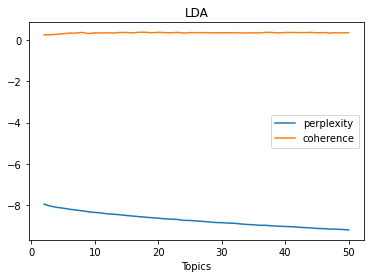

In [22]:
# Plot results
x = list(range(min_topic,max_topic+1))
plt.plot(x,list(perplexity_result.values()), label = "perplexity")
plt.plot(x,list(coherence_result.values()), label = "coherence")
plt.xlabel("Topics")
plt.title("LDA")
plt.legend()
plt.show()

In [23]:
id2word, data_words, corpus = preprocess_LDA(data_words)
topic_num = 8
topic_top_tweets = get_top_tweets(lda_models_list[topic_num], corpus, topic_num, 20)

In [24]:
# Print out topic words
pprint(lda_models_list[topic_num].print_topics())

[(0,
  '0.044*"store" + 0.042*"grocery" + 0.022*"go" + 0.021*"supermarket" + '
  '0.014*"get" + 0.009*"toiletpaper" + 0.009*"socialdistancing" + '
  '0.009*"shopping" + 0.009*"people" + 0.008*"work"'),
 (1,
  '0.019*"online" + 0.013*"shopping" + 0.012*"people" + 0.010*"price" + '
  '0.009*"food" + 0.008*"go" + 0.008*"help" + 0.008*"get" + 0.007*"store" + '
  '0.006*"time"'),
 (2,
  '0.036*"food" + 0.012*"demand" + 0.011*"consumer" + 0.009*"help" + '
  '0.007*"supermarket" + 0.007*"bank" + 0.007*"stock" + 0.006*"people" + '
  '0.006*"need" + 0.005*"essential"'),
 (3,
  '0.036*"price" + 0.016*"food" + 0.011*"supply" + 0.007*"time" + '
  '0.007*"demand" + 0.007*"lockdown" + 0.006*"go" + 0.006*"say" + '
  '0.006*"people" + 0.006*"scam"'),
 (4,
  '0.032*"sanitizer" + 0.031*"hand" + 0.022*"supermarket" + 0.017*"worker" + '
  '0.013*"mask" + 0.012*"people" + 0.009*"make" + 0.008*"use" + 0.007*"store" '
  '+ 0.006*"price"'),
 (5,
  '0.037*"consumer" + 0.013*"business" + 0.010*"easter" + 0.008*

In [25]:
# Print out topic tweets
for i in range(topic_num):
    print(f"Topic {i}")
    pprint(display_text_LDA(topic_top_tweets,i))
    print()

Topic 0
array(['Stepped out after 7 days self isolation to get food Good to see my local Carrefour supermarket putting in place measures on physical distancing at the checkout counters In aisles people seem to abiding Most items includ fresh fruits vegetables available',
       "It's quite true. I walked to grocery store yesterday at 5pm (peak rush hour usually) and I was able to cross mid street because there were a lot less cars out there. There's still folks around but it was for groceries typically. #coronavirus going real ham. Now to see markets... https://t.co/eqWtCjtutH",
       'Hey, can yÂ\x92all stop panic buying groceries? My @HEB curbside is AN ENTIRE WEEK OUT. This never happens. \r\r\n\r\r\nI appreciate all of the hard working grocery store people. I know how stressful it is during a busy time. Keep it up!! \r\r\n\r\r\nFor the rest of you...chill out.\r\r\n#Hoarding #Covid_19',
       'My Mom amp Dad are getting worried about me working at the grocery store because of the

#### NMF

In [26]:
# https://stackoverflow.com/questions/54941966/how-can-i-calculate-perplexity-using-nltk
# Self-defined method to calculate the perplexity
def calculate_perplexity_NMF(NMF_result, topic_num, top_words):
    word_prob = dict()
    for i in range(topic_num):
        for word in NMF_result[i]:
            if word in word_prob.keys():
                word_prob[word] += 1
            else:
                word_prob[word] = 0

    word_prob = {key: value/topic_num for key, value in word_prob.items()}

    for i in range(topic_num):
        perplexity = 0
        for word in NMF_result[i]:
            if word_prob[word] != 0:
                perplexity += np.log2(word_prob[word])
                # print(perplexity,word_prob[word])

    perplexity /= (top_words*topic_num)
    return np.power(2, -perplexity)

# Apply NMF
def apply_NMF(data_words,min_topic,max_topic, top_words = 5):
    # vect = CountVectorizer(stop_words=stop_words,analyzer='word', ngram_range=(1,1), min_df = 0.01)
    vect = CountVectorizer(stop_words=stop_words,analyzer='word', ngram_range=(1,1))
    X = vect.fit_transform([" ".join(i) for i in data_words])
    
    topic_results_list = dict()
    topic_tweets_results= dict()
    perplexity_results = dict()
    # X(document, words) = mode.transform(X)(document, topic_number) * components_df(topic_number, words)

    for topic_num in range(min_topic, max_topic+1):
        topic_results = dict()
        # Define model
        model = NMF(n_components=topic_num, random_state=5)
        model.fit(X)

        features = vect.get_feature_names()
        components_df = pd.DataFrame(model.components_, columns=features)

    
        for topic_idx, probability in enumerate(model.components_):
            # print(f"Topic {topic_idx}: ", end="")
            top_words_idx = probability.argsort()[:-top_words - 1:-1]
            word_results = ", ".join(features[i] for i in top_words_idx)
            # print(word_results)
            topic_results[topic_idx] = word_results.split(", ")


        perplexity = calculate_perplexity_NMF(topic_results,topic_num = topic_num, top_words = top_word)
        print(f"Topic: {topic_num}      Perplexity: {perplexity}")
        topic_tweets = pd.DataFrame(model.transform(X))
        topic_tweets_results[topic_num] = topic_tweets
        perplexity_results[topic_num] = perplexity
        topic_results_list[topic_num] = topic_results
    return topic_results_list, topic_tweets_results, perplexity_results

# Display the tweets for each topic
def display_text_NMF(topic_tweets, topic_idx, max_doc=20):

    idx = topic_tweets.sort_values(by=topic_idx, ascending=False).head(max_doc).index
    return df.iloc[idx]["OriginalTweet"].values


In [27]:
top_word = 20
# Apply NMF model
topic_results_list, topic_tweets_results, perplexity_results = apply_NMF(data_words, min_topic,max_topic, top_words = top_word)

Topic: 2      Perplexity: 1.0717734625362931
Topic: 3      Perplexity: 1.2090800726426305
Topic: 4      Perplexity: 1.2249203730799776
Topic: 5      Perplexity: 1.0978218315308366
Topic: 6      Perplexity: 1.05543086789017
Topic: 7      Perplexity: 1.1805563181680896
Topic: 8      Perplexity: 1.1516943208503627
Topic: 9      Perplexity: 1.1201823977673016
Topic: 10      Perplexity: 1.0653056984176261
Topic: 11      Perplexity: 1.1325955291456242
Topic: 12      Perplexity: 1.1290281509154698
Topic: 13      Perplexity: 1.1128450700808334
Topic: 14      Perplexity: 1.1174001660869604
Topic: 15      Perplexity: 1.0986490648156684
Topic: 16      Perplexity: 1.0974345880000533
Topic: 17      Perplexity: 1.106942199107983
Topic: 18      Perplexity: 1.0860803385271323
Topic: 19      Perplexity: 1.0774625122108121
Topic: 20      Perplexity: 1.0857731239779853
Topic: 21      Perplexity: 1.0870687803529113
Topic: 22      Perplexity: 1.091215044931838
Topic: 23      Perplexity: 1.0859931836574879


In [28]:
# save(topic_results_list, "topic_results_list_nmf")
# save(topic_tweets_results, "topic_tweets_results_nmf")
# save(perplexity_results, "perplexity_results_nmf")

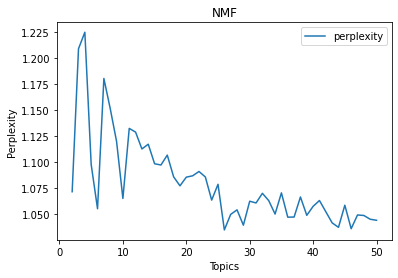

In [29]:
# Plot result
x = list(range(min_topic,max_topic+1))
plt.plot(x,list(perplexity_results.values()), label = "perplexity")
plt.xlabel("Topics")
plt.ylabel("Perplexity")
plt.title("NMF")
plt.legend()
plt.show()

In [30]:
# topic_tweets_results = load("topic_tweets_results_nmf")
# topic_results_list = load("topic_results_list_nmf")

In [31]:
topic_num = 6

In [32]:
# Print topic words
for key, value in topic_results_list[topic_num].items():
    print(f"topic {key}: ", ", ".join(value))

topic 0:  store, grocery, go, worker, work, get, people, retail, employee, time, online, shopping, line, thank, close, day, say, home, see, essential
topic 1:  price, oil, low, market, pandemic, due, increase, gas, fall, high, demand, drop, time, see, take, supply, say, crisis, global, go
topic 2:  food, panic, stock, demand, buy, supply, need, people, bank, help, buying, get, increase, due, chain, say, shortage, pandemic, stop, keep
topic 3:  supermarket, people, go, get, work, worker, shop, shelf, time, shopping, home, need, buy, day, staff, online, see, delivery, local, take
topic 4:  consumer, online, business, pandemic, shopping, change, impact, help, behavior, new, time, crisis, report, good, demand, due, see, take, product, economy
topic 5:  hand, sanitizer, make, use, mask, wash, soap, help, alcohol, stay, glove, home, face, need, safe, water, keep, bottle, get, people


In [33]:
# Print tweets
for i in range(topic_num):
    print(f"Topic {i}")
    pprint(display_text_NMF(topic_tweets_results[topic_num], i, max_doc=20))
    print()

Topic 0
array(['I know a lot of grocery stores are low on stock of some items. If you need something right away, try the Dollar Store, bodegas, 7-11, drug stores or ask friends/neighbors. I found some things the grocery store was sold out of at the Dollar Store yesterday. #coronavirus',
       "Had to stop at 4 stores. Only health food store employees had masks, not fabric store w/ mask making customers, not lg grocery stores, not Fed. Post Office. #SocialDistancing won't work if store employees aren't protected &amp; protecting us.?\r\r\n\r\r\n#Montana #Helena #COVID19 #coronavirus",
       "Sick people - Please STOP going to the grocery store! Order delivery! It's called self isolation! I'm tired of seeing people with coronavirus at the grocery store. Restaurants are more sanitary than the grocery stores! I'm ordering take-out, it's safer! #coronavirus",
       'If you can use an app and pick-up at the grocery store that is best. If the grocery stores are not app capable they should 

#### BTM

In [34]:
# Apply BTM model
def apply_BTM(data_words, min_topic=2,max_topic=5, top_words=10):
    texts = [" ".join(i) for i in data_words]
    X, vocabulary, vocab_dict = btm.get_words_freqs(texts, stop_words=stop_words)
    docs_vec = btm.get_vectorized_docs(texts, vocabulary)
    biterms = btm.get_biterms(docs_vec)

    perplexity_list = dict()
    coherence_list = dict()
    BTM_model_list = dict()
    phi_list = dict()

    for num_topic in range(min_topic, max_topic+1):
        # Initializing and running model
        model = btm.BTM(X, vocabulary, seed=5, T=num_topic, M=top_words)
        model.fit(biterms, iterations=20,verbose =False)

        perplexity = model.perplexity_
        coherence = np.average(model.coherence_)

        print(f"Topic {num_topic} Done: Perplexity: {perplexity}  Coherence Score: {coherence}")

        phi = tmp.get_phi(model)
        perplexity_list[num_topic] = perplexity
        coherence_list[num_topic] = coherence
        BTM_model_list[num_topic] = model
        phi_list[num_topic] = phi
    return perplexity_list, coherence_list, BTM_model_list, phi_list

# Display topic words
def display_BTM(phi, words_num=5):
    for i in phi.columns:
        top_words = phi.sort_values(by=i, ascending = False).head(words_num).index.tolist()
        word_results = ", ".join(top_words) 
        print(f"Topic {i}: {word_results}")
# Display tweets
def display_text_BTM(model,data_words,max_doc=20):
    texts = [" ".join(i) for i in data_words]
    return btm.get_top_topic_docs(texts, model.matrix_docs_topics_, docs_num = max_doc)

In [35]:
# Run BTM
perplexity_result, coherence_result, BTM_model_list, phi_list= apply_BTM(data_words,min_topic,max_topic)

Topic 2 Done: Perplexity: 2.1875238037828842e+162  Coherence Score: -115.15455866258


/usr/local/lib/python3.7/dist-packages/tmplot/_helpers.py:39: UserWarning: Please install "tomotopy" package to analyze its models.
Run `pip install tomotopy` in the console.
  f'Please install "{package_name}" package to analyze its models.\n'


Topic 3 Done: Perplexity: inf  Coherence Score: -112.62665341008005
Topic 4 Done: Perplexity: 3.242392218353342e+292  Coherence Score: -114.07491934303334
Topic 5 Done: Perplexity: 1.078013654627381e+298  Coherence Score: -116.4797715010387
Topic 6 Done: Perplexity: inf  Coherence Score: -114.72335283213549
Topic 7 Done: Perplexity: inf  Coherence Score: -112.05755256955419
Topic 8 Done: Perplexity: 1.0  Coherence Score: -117.50736593058973
Topic 9 Done: Perplexity: 2.7206672601958562e+34  Coherence Score: -117.54514862233539
Topic 10 Done: Perplexity: 8.574213319649848e+127  Coherence Score: -115.187736071978
Topic 11 Done: Perplexity: 52.974265593502984  Coherence Score: -113.30562871465335
Topic 12 Done: Perplexity: 169.9698789212658  Coherence Score: -112.96690846088353
Topic 13 Done: Perplexity: inf  Coherence Score: -118.54328056633169
Topic 14 Done: Perplexity: inf  Coherence Score: -114.19905781792896
Topic 15 Done: Perplexity: inf  Coherence Score: -115.42526789350015
Topic 16

In [36]:
# save(perplexity_result, "perplexity_btm")
# save(coherence_result, "coherence_btm")
# save(BTM_model_list,"models_btm")
# save(phi_list,"phi_btm")

In [37]:
# perplexity_result=load("perplexity_btm")
# coherence_result=load( "coherence_btm")
# BTM_model_list=load("models_btm")
# phi_list=load("phi_btm")

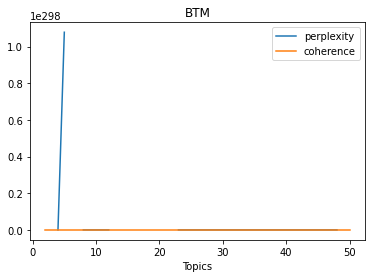

In [38]:
# Plot result
x = list(range(min_topic,max_topic+1))
plt.plot(x,list(perplexity_result.values()), label = "perplexity")
plt.plot(x,list(coherence_result.values()), label = "coherence")
plt.xlabel("Topics")
plt.title("BTM")
plt.legend()
plt.show()

In [39]:
topic_num = 6
phi = phi_list[topic_num]

In [40]:
# tmp.calc_terms_probs_ratio(phi, topic=4, lambda_=1)
# terms_probs.sort_values(by="Probability", ascending = False).head(10)["Terms"].to_list()
# Display topic words
for i in phi.columns:
    top_words = phi.sort_values(by=i, ascending = False).head(10).index.tolist()
    word_results = ", ".join(top_words) 
    print(f"Topic {i}: {word_results}")

Topic 0: consumer, online, shopping, price, store, business, help, time, pandemic, retail
Topic 1: supermarket, go, people, store, hand, grocery, sanitizer, get, mask, buy
Topic 2: store, grocery, supermarket, worker, people, go, work, get, food, delivery
Topic 3: food, panic, people, price, buy, need, supermarket, store, stock, go
Topic 4: food, price, consumer, hand, supply, supermarket, sanitizer, store, people, demand
Topic 5: price, consumer, oil, demand, pandemic, market, due, impact, low, food


In [41]:
# Display tweets
display_text_BTM(BTM_model_list[topic_num],data_words)

topic0  \
0   interesting read consumer trend pandemic half ...   
1   cart wipe supply limit fixturescloseup fixture...   
2   love artist pay tribute people frontline pande...   
3   globally price crude oil drop year low percent...   
4   opposite price globally fall rise price crude ...   
5   thing expect drop price result drop global pri...   
6   ironically price increase percent retailer say...   
7   always crap disintereste come computer game ev...   
8         surge point recovery effort oil price spike   
9   raw video warn random person stop restaurant s...   
10  save job maybe even live learn national shorta...   
11  well start stock pile food homeless starve cau...   
12  price pandemic force majeure mining firm use s...   
13  positive die car accident way grocery store de...   
14  itâ important ever get consumer good store sh...   
15  major supermarket chain begin report first rel...   
16  stop shop avoid lcbo lineup beer takeout food ...   
17  pandemic semiconductor price expect stabilize ...   
18  starâ hardy hibiscus unique flower shape beau...   
19             food price soar threat newhumanitarian   

                                               topic1  \
0   cart wipe supply limit fixturescloseup fixture...   
1   love artist pay tribute people frontline pande...   
2   globally price crude oil drop year low percent...   
3   opposite price globally fall rise price crude ...   
4   thing expect drop price result drop global pri...   
5   ironically price increase percent retailer say...   
6   always crap disintereste come computer game ev...   
7         surge point recovery effort oil price spike   
8   raw video warn random person stop restaurant s...   
9   interesting read consumer trend pandemic half ...   
10  well start stock pile food homeless starve cau...   
11  price pandemic force majeure mining firm use s...   
12  positive die car accident way grocery store de...   
13  itâ important ever get consumer good store sh...   
14  major supermarket chain begin report first rel...   
15  stop shop avoid lcbo lineup beer takeout food ...   
16  pandemic semiconductor price expect stabilize ...   
17  starâ hardy hibiscus unique flower shape beau...   
18             food price soar threat newhumanitarian   
19  restriction evident morning little vehicle tra...   

                                               topic2  \
0   positive die car accident way grocery store de...   
1   cart wipe supply limit fixturescloseup fixture...   
2   love artist pay tribute people frontline pande...   
3   globally price crude oil drop year low percent...   
4   opposite price globally fall rise price crude ...   
5   thing expect drop price result drop global pri...   
6   ironically price increase percent retailer say...   
7   always crap disintereste come computer game ev...   
8         surge point recovery effort oil price spike   
9   raw video warn random person stop restaurant s...   
10  interesting read consumer trend pandemic half ...   
11  well start stock pile food homeless starve cau...   
12  price pandemic force majeure mining firm use s...   
13  itâ important ever get consumer good store sh...   
14  major supermarket chain begin report first rel...   
15  stop shop avoid lcbo lineup beer takeout food ...   
16  pandemic semiconductor price expect stabilize ...   
17  starâ hardy hibiscus unique flower shape beau...   
18             food price soar threat newhumanitarian   
19  restriction evident morning little vehicle tra...   

                                               topic3  \
0   love artist pay tribute people frontline pande...   
1   globally price crude oil drop year low percent...   
2   opposite price globally fall rise price crude ...   
3   thing expect drop price result drop global pri...   
4   ironically price increase percent retailer say...   
5   always crap disintereste come computer game ev...   
6         surge point recovery effort oil price spike 

#### CorEx

In [42]:
#github example here: https://github.com/gregversteeg/corex_topic
import numpy as np
import scipy.sparse as ss
from corextopic import corextopic as ct

# Apply corex model
def apply_Corex(data_words, min_topic=2, max_topic=10, anchor_words = None):

    tc_list = dict()
    model_list = dict()

    vect = CountVectorizer(stop_words=stop_words,analyzer='word', ngram_range=(1,1), min_df = 0.01)
    X = vect.fit_transform([" ".join(i) for i in data_words])


    X = ss.csr_matrix(X)
    for num_topic in range(min_topic, max_topic+1):
        # Train the CorEx topic model
        model = ct.Corex(n_hidden=num_topic, verbose = False, seed=5)  # Define the number of latent (hidden) topics to use.
        # topic_model.fit(X, words=words, docs=docs)
        words = vect.get_feature_names()
        model.fit(X, words = words, anchors=anchor_words)
        print(f"Topic {num_topic} Total Covraiance: {model.tc}")
        model_list[num_topic] = model
        tc_list[num_topic] = model.tc
    return tc_list, model_list

# Display topic words
def display_corex(topics, words_num=5):
    for topic_idx,topic in enumerate(topics):
        
        # w: word, mi: mutual information, s: sign
        topic = [w if s > 0 else ('~'+w) for w,_,s in topic]
        results = ", ".join(topic[:words_num])
        print(f"Topic {topic_idx}: {results}")

# Display tweets
def display_text_corex(model, topic_idx, max_doc=20):
    top_tweets = model.get_top_docs(topic=topic_idx, n_docs=max_doc)
    idx = [i[0] for i in top_tweets]
    return df.iloc[idx]["OriginalTweet"].values

In [43]:
# Run corex model without anchor words
tc_result, corex_models = apply_Corex(data_words,min_topic, max_topic)

Topic 2 Total Covraiance: 0.6796313515935585
Topic 3 Total Covraiance: 0.7131143642561579
Topic 4 Total Covraiance: 0.9234028618095651
Topic 5 Total Covraiance: 0.8667332151514651
Topic 6 Total Covraiance: 0.995049004269764
Topic 7 Total Covraiance: 1.0393319273258572
Topic 8 Total Covraiance: 1.015681722946196
Topic 9 Total Covraiance: 0.9681177055481763
Topic 10 Total Covraiance: 1.0888262016093406
Topic 11 Total Covraiance: 1.0620752153360877
Topic 12 Total Covraiance: 1.1989962755864674
Topic 13 Total Covraiance: 1.0404149159643177
Topic 14 Total Covraiance: 1.031165763897683
Topic 15 Total Covraiance: 1.112850848183793
Topic 16 Total Covraiance: 1.1745030663707459
Topic 17 Total Covraiance: 1.1313805918049533
Topic 18 Total Covraiance: 1.053228320033918
Topic 19 Total Covraiance: 1.0903365715582745
Topic 20 Total Covraiance: 1.0874753028593682
Topic 21 Total Covraiance: 1.0847188528340568
Topic 22 Total Covraiance: 1.080533795961197
Topic 23 Total Covraiance: 0.9985794652140983
To

In [44]:
# save(tc_result, "tc_corex")
# save(corex_models, "models_corex")

In [45]:
# tc_result=load( "tc_corex")
# corex_models = load( "models_corex")

In [46]:
# tc_result = load("tc_corex")

Text(0.5, 1.0, 'CorEx')

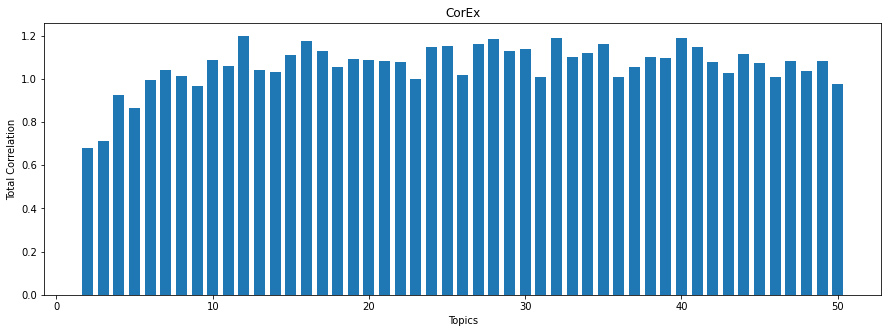

In [47]:
# Plot results
plt.figure(figsize = (15, 5))
plt.bar(tc_result.keys(), tc_result.values(),width = 0.7)
plt.xlabel("Topics")
plt.ylabel("Total Correlation")
plt.title("CorEx")

In [48]:
# Display topic words
topic_num = 12
display_corex(corex_models[topic_num].get_topics())

Topic 0: store, grocery, ~consumer, retail, worker
Topic 1: price, oil, ~supermarket, low, gas
Topic 2: hand, sanitizer, mask, glove, wear
Topic 3: online, shopping, shop, delivery, order
Topic 4: food, demand, supply, stock, chain
Topic 5: toilet, paper, toiletpaper, roll, find
Topic 6: stay, social, home, safe, distancing
Topic 7: go, people, get, shelf, empty
Topic 8: panic, buying, buy, stop, fear
Topic 9: support, help, community, business, small
Topic 10: week, last, month, next, year
Topic 11: change, behavior, shift, new, pandemic


In [49]:
# Display tweets
model = corex_models[topic_num]
for i in range(topic_num):
    print(f"Topic {i}")
    pprint(display_text_corex(model, i, max_doc=20))
    print()

Topic 0
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
array(['We wanted to take a moment to thank all of those working on the front lines to combat COVID-19. Healthcare workers, those in manufacturing and transportation, retail and grocery store employees, scientists, and everyone working from home to flatten the curve: THANK YOU. https://t.co/crCVrL9CQI',
       'All stores (except: grocery stores or pharmacies) should not have open doors. No one needs to buy anything other than essentials right now. CLOSE YOUR DOORS, keep your employees and customers safe! #coronavirus #closeyourdoors',
       'something to think of for hospital staff EMTs social workers counselors emergency service repair grocery essential retail store employees anyone i forgot amp friends family worth the read',
       'THANK YOU GROCERY STORE EMPLOYEES, FARMERS, TRUCKERS, HEALTHCARE WORKERS, RETAIL EMPLOYEES THAT ARE STILL WORKING, AND ALL OTHER ESSENTIAL INDIVIDUALS OFFERING YOUR 

In [50]:
# Run corex with anchor words
tc_result_anchor, corex_models_anchor = apply_Corex(data_words,min_topic, max_topic,anchor_words=["food"])

Topic 2 Total Covraiance: 0.6300917160420514
Topic 3 Total Covraiance: 0.8133686344979423
Topic 4 Total Covraiance: 0.9073658327153103
Topic 5 Total Covraiance: 0.8539569826573271
Topic 6 Total Covraiance: 0.9532723864497616
Topic 7 Total Covraiance: 0.9838789089341891
Topic 8 Total Covraiance: 1.0846508099529963
Topic 9 Total Covraiance: 1.076433787430413
Topic 10 Total Covraiance: 1.015135137902477
Topic 11 Total Covraiance: 1.1161074677069591
Topic 12 Total Covraiance: 1.2067696320085515
Topic 13 Total Covraiance: 1.0891268239150675
Topic 14 Total Covraiance: 1.2184295670201652
Topic 15 Total Covraiance: 1.1863494850537992
Topic 16 Total Covraiance: 1.2170767005866634
Topic 17 Total Covraiance: 1.1641372097553968
Topic 18 Total Covraiance: 1.046648240829894
Topic 19 Total Covraiance: 1.0922479113863637
Topic 20 Total Covraiance: 1.0673711136191435
Topic 21 Total Covraiance: 1.2334154988729555
Topic 22 Total Covraiance: 1.1238833421091727
Topic 23 Total Covraiance: 1.0735491781213873

In [51]:
# save(tc_result_anchor, "tc_corex_anchor")
# save(corex_models_anchor, "models_corex_anchor")
# tc_result_anchor = load("tc_result_anchor")

In [52]:
# tc_result_anchor = load( "tc_corex_anchor")
# corex_models_anchor= load( "models_corex_anchor")

Text(0.5, 1.0, 'CorEx with anchor word "food"')

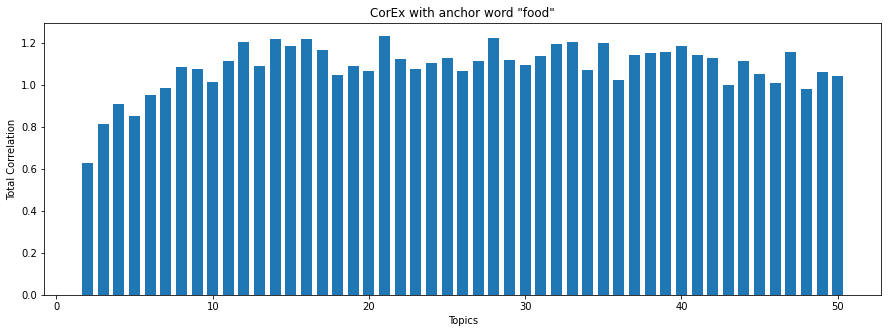

In [53]:
plt.figure(figsize = (15, 5))
plt.bar(tc_result_anchor.keys(), tc_result_anchor.values(),width = 0.7)
plt.xlabel("Topics")
plt.ylabel("Total Correlation")
plt.title("CorEx with anchor word \"food\"")

In [54]:
topic_num = 12
display_corex(corex_models_anchor[topic_num].get_topics())

Topic 0: food, panic, stock, buy, buying
Topic 1: make, sure
Topic 2: consumer, ~supermarket, demand, impact, business
Topic 3: people, get, work, time, itâ
Topic 4: online, shopping, shop, delivery, order
Topic 5: toilet, paper, toiletpaper, roll, find
Topic 6: price, oil, fall, market, high
Topic 7: stay, social, safe, distancing, home
Topic 8: low, year, gas, old, drop
Topic 9: store, grocery, retail, employee, go
Topic 10: hand, sanitizer, mask, glove, wear
Topic 11: worker, driver, health, staff, thank


In [55]:
model = corex_models_anchor[topic_num]
for i in range(topic_num):
    print(f"Topic {i}")
    pprint(display_text_corex(model, i, max_doc=20))
    print()

Topic 0
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
array(["@munro_burton There's empty shelves because of the panic buying. There's no issue at all with the food supply chain. *BUT THERE WILL BE IF PEOPLE KEEP BUYING 10kg rice THEY'LL STILL BE USING UP NEXT CHRISTMAS.* #Sainsburys #COVID2019 #JeremyVine #LeaveEno",
       "Supplies of food &amp; toiletry items are just fine, it's panic buying &amp; hoarding that's emptying shelves faster than truckers can transport the supplies. #Coronavirus is bad enough, let's not make it worse by denying people fair access to stuff they need at their stores. Chill folks",
       'No shortage of food here As a wave of panic buying strikes many of the nation s biggest retailers due to as they work around the clock to transport and supply goods to fill empty shelves',
       "Nice assurance from #Malaysia PM but there are panic buying &amp; shortages of essential supplies in Msia too. It's political suicide for the n

### Experiment 1 - Topics Over Time(Seasons)

#### Data Prepare

In [56]:
df

UserName  ScreenName                        Location     TweetAt  \
0         29779       74731            Brooklyn / the world  01-04-2020   
1         29349       74301   Ginninderra Creek Canberra Oz  01-04-2020   
2         29350       74302                    Brooklyn, NY  01-04-2020   
3         29351       74303                          London  01-04-2020   
4         29352       74304                  las cruces,nm   01-04-2020   
...         ...         ...                             ...         ...   
32562     42982       87934       Adelaide, South Australia  12-04-2020   
32563     42979       87931                Karachi Pakistan  12-04-2020   
32564     42978       87930                         NY & NJ  12-04-2020   
32565     42975       87927                Bedford, England  12-04-2020   
32566     42847       87799                   Kenya??AFRICA  12-04-2020   

                                           OriginalTweet           Sentiment  \
0      World risks food crisis in wake of coronavirus...  Extremely Negative   
1      The Canberra Relief Network CRN is the ACT Gov...            Positive   
2      I worked at a nightclub. I lived shift to shif...  Extremely Positive   
3      Think all the 'extra' supermarkets need to clo...            Negative   
4      Lowe's closes Harper Woods store to customers ...            Positive   
...                                                  ...                 ...   
32562  Gratitunes is a consumer-generated music platf...  Extremely Positive   
32563  @RamzanChhipa Thanks @RamzanChhipa \r\r\n\r\r\...            Positive   
32564  "Yearly Passover Food Distribution" outdoor wi...            Positive   
32565  Coronavirus can linger in air for a long time,...            Positive   
32566  OPEC has agreed to Cut Oil Production by 9.7 M...            Positive   

        datetime  month                                            hashtag  \
0     2020-01-04      1                                                 []   
1     2020-01-04      1                                                 []   
2     2020-01-04      1                               [coronavirus, COVID]   
3     2020-01-04      1              [lockdown, coronavirus, Supermarkets]   
4     2020-01-04      1                                                 []   
...          ...    ...                                                ...   
32562 2020-12-04     12                                                 []   
32563 2020-12-04     12  [HandGloves, Mask, Sanitizer, COVID__19, Coron...   
32564 2020-12-04     12                                                 []   
32565 2020-12-04     12                                                 []   
32566 2020-12-04     12                                                 []   

                                          text_processed  
0      world risks food crisis in wake of coronavirus...  
1      the canberra relief network crn is the act gov...  
2      i worked at a nightclub i lived shift to shift...  
3      think all the  extra  supermarkets need to clo...  
4      lowe s closes harper woods store to customers ...  
...                                                  ...  
32562  gratitunes is a consumer generated music platf...  
32563   ramzanchhipa thanks  ramzanchhipa  handgloves...  
32564   yearly passover food distribution  outdoor wi...  
32565  coronavirus can linger in air for a long time ...  
32566  opec has agreed to cut oil production by   mil...  

[32567 rows x 10 columns]

In [57]:
# Create map of the season
season_dict = {
    1: "spring",
    2: "spring",
    3: "spring",
    4: "summer",
    5: "summer",
    6: "summer",
    7: "autumn",
    8: "autumn",
    9: "autumn",
    10: "winter",
    11: "winter",
    12: "winter",
}

In [58]:
df["season"] = df["month"].map(season_dict)

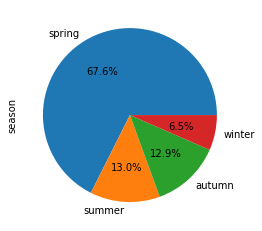

In [59]:
# Plot proportion of the data in season
df["season"].value_counts(normalize=True).plot.pie(autopct = "%.1f%%")

In [60]:
df_spring = df.loc[(df["season"]=="spring")].reset_index(drop=True)
df_summer = df.loc[(df["season"]=="summer")].reset_index(drop=True)
df_autumn = df.loc[(df["season"]=="autumn")].reset_index(drop=True)
df_winter = df.loc[(df["season"]=="winter")].reset_index(drop=True)

In [61]:
# Get data words for each season
data_words_list= {
    "spring":get_data_words(df_spring),
    "summer": get_data_words(df_summer),
    "autumn" : get_data_words(df_autumn),
    "winter" : get_data_words(df_winter)   
}

In [62]:
# save(data_words_list, "data_words_list_seasons")

In [63]:
# data_words_list = load("data_words_list_seasons")

In [64]:
display_wordcloud(df_spring,50, stop_words=stop_words, title = "spring")

In [65]:
display_wordcloud(df_summer,50, stop_words=stop_words, title = "summer")

In [66]:
display_wordcloud(df_autumn,50, stop_words=stop_words, title = "autumn")

In [67]:
display_wordcloud(df_winter,50, stop_words=stop_words, title = "winter")

In [68]:
min_topic = 2
max_topic = 50

#### LDA

In [69]:
# Run LDA
perplexity_result, coherence_result, lda_result = dict(),dict(),dict()
for key, data_words in data_words_list.items():
    print(f"============================{key} Start LDA ============================")

    perplexity, coherence, model = apply_LDA(data_words, min_topic, max_topic)
    perplexity_result[key] = perplexity
    coherence_result[key] = coherence
    lda_result[key] = model

# save(lda_result,f"season_lda")

============================spring Start LDA ============================
Topic 2 Done: Perplexity: -8.131086655143408  Coherence Score: 0.2133179555905393
Topic 3 Done: Perplexity: -8.15058805625763  Coherence Score: 0.2966651799268616
Topic 4 Done: Perplexity: -8.2304666256338  Coherence Score: 0.3148492353535388
Topic 5 Done: Perplexity: -8.293629432637863  Coherence Score: 0.3789417951017883
Topic 6 Done: Perplexity: -8.335321740174663  Coherence Score: 0.3252017774116757
Topic 7 Done: Perplexity: -8.37704392054568  Coherence Score: 0.3608355280919742
Topic 8 Done: Perplexity: -8.42117151863504  Coherence Score: 0.32897578568868147
Topic 9 Done: Perplexity: -8.482633504380317  Coherence Score: 0.31448760986167484
Topic 10 Done: Perplexity: -8.506065558020973  Coherence Score: 0.33279187155529755
Topic 11 Done: Perplexity: -8.542537304566176  Coherence Score: 0.2799302654714165
Topic 12 Done: Perplexity: -8.57823933530308  Coherence Score: 0.3236239728840031
Topic 13 Done: Perplexit

Topic 50 Done: Perplexity: -9.291278635860083  Coherence Score: 0.28624795177948203
============================summer Start LDA ============================


Topic 2 Done: Perplexity: -8.095790690946805  Coherence Score: 0.23059296980123065


Topic 3 Done: Perplexity: -8.214603042859887  Coherence Score: 0.23895628465717844


Topic 4 Done: Perplexity: -8.314750339784254  Coherence Score: 0.2518022209230709


Topic 5 Done: Perplexity: -8.400812415839066  Coherence Score: 0.24631853670005333


Topic 6 Done: Perplexity: -8.466510291078556  Coherence Score: 0.23772649229316148


Topic 7 Done: Perplexity: -8.532502721172426  Coherence Score: 0.24217910625412783


Topic 8 Done: Perplexity: -8.584941868747167  Coherence Score: 0.25308938103359774


Topic 9 Done: Perplexity: -8.63810736673593  Coherence Score: 0.24901067006063593


Topic 10 Done: Perplexity: -8.676081906426218  Coherence Score: 0.2722950660079594


Topic 11 Done: Perplexity: -8.73077034457869  Coherence Score: 0.2805608400149005


Topic 12 Done: Perplexity: -8.777704913527796  Coherence Score: 0.2688983721725889


Topic 13 Done: Perplexity: -8.818816708770711  Coherence Score: 0.25027380300441404


Topic 14 Done: Perplexity: -8.858554006469596  Coherence Score: 0.2569771973206148


Topic 15 Done: Perplexity: -8.906438863514833  Coherence Score: 0.2956651765094716


Topic 16 Done: Perplexity: -8.940305829227846  Coherence Score: 0.2500329665500557


Topic 17 Done: Perplexity: -8.974280847329899  Coherence Score: 0.2869420270092982


Topic 18 Done: Perplexity: -9.008345627921457  Coherence Score: 0.2582584293828478


Topic 19 Done: Perplexity: -9.049832929647039  Coherence Score: 0.2615311308298529


Topic 20 Done: Perplexity: -9.079290152782939  Coherence Score: 0.27102237335059687


Topic 21 Done: Perplexity: -9.11268699465775  Coherence Score: 0.2688664313000439


Topic 22 Done: Perplexity: -9.136521907127426  Coherence Score: 0.29204234462198597


Topic 23 Done: Perplexity: -9.188737332108571  Coherence Score: 0.2754768333671913


Topic 24 Done: Perplexity: -9.2075276253251  Coherence Score: 0.26754744530380975


Topic 25 Done: Perplexity: -9.232165496545722  Coherence Score: 0.26774698613664777


Topic 26 Done: Perplexity: -9.255979569872753  Coherence Score: 0.27149121090240913


Topic 27 Done: Perplexity: -9.286827282731485  Coherence Score: 0.2797658699661402


Topic 28 Done: Perplexity: -9.32760734626998  Coherence Score: 0.27465575763891625


Topic 29 Done: Perplexity: -9.33747183154699  Coherence Score: 0.26674387758648865


Topic 30 Done: Perplexity: -9.358331517890914  Coherence Score: 0.2709970112980176


Topic 31 Done: Perplexity: -9.390829342823242  Coherence Score: 0.28355059526664955


Topic 32 Done: Perplexity: -9.417283574536345  Coherence Score: 0.28949578449501023


Topic 33 Done: Perplexity: -9.430077782730475  Coherence Score: 0.2616107691648947


Topic 34 Done: Perplexity: -9.474126408653234  Coherence Score: 0.28487454076587426


Topic 35 Done: Perplexity: -9.473093386354137  Coherence Score: 0.28043938613340114


Topic 36 Done: Perplexity: -9.515002895681642  Coherence Score: 0.29653589378289186


Topic 37 Done: Perplexity: -9.544774953252984  Coherence Score: 0.28515704520321555


Topic 38 Done: Perplexity: -9.575974923786344  Coherence Score: 0.2844497196046132


Topic 39 Done: Perplexity: -9.583183369429806  Coherence Score: 0.2897712678410037


Topic 40 Done: Perplexity: -9.610232004419474  Coherence Score: 0.2812887004997014


Topic 41 Done: Perplexity: -9.624892377736598  Coherence Score: 0.26924289528674045


Topic 42 Done: Perplexity: -9.639087025268253  Coherence Score: 0.307068448668615


Topic 43 Done: Perplexity: -9.669005967734309  Coherence Score: 0.2753614697637702


Topic 44 Done: Perplexity: -9.686524086392682  Coherence Score: 0.26916345656453927


Topic 45 Done: Perplexity: -9.702282964627315  Coherence Score: 0.26876585244680723


Topic 46 Done: Perplexity: -9.712635306895047  Coherence Score: 0.2840683170628693


Topic 47 Done: Perplexity: -9.726870858105853  Coherence Score: 0.29053023843230746


Topic 48 Done: Perplexity: -9.776725773007461  Coherence Score: 0.27499911283418293


Topic 49 Done: Perplexity: -9.780070222950764  Coherence Score: 0.2790191961269815


Topic 50 Done: Perplexity: -9.790540871763246  Coherence Score: 0.29652456199367644
============================autumn Start LDA ============================


Topic 2 Done: Perplexity: -8.134881178085319  Coherence Score: 0.20547203511243317


Topic 3 Done: Perplexity: -8.24211559496036  Coherence Score: 0.23341713434839673


Topic 4 Done: Perplexity: -8.335738428307284  Coherence Score: 0.2405455765347583


Topic 5 Done: Perplexity: -8.39565430865601  Coherence Score: 0.23142350167964282


Topic 6 Done: Perplexity: -8.484457546457987  Coherence Score: 0.2565363100636584


Topic 7 Done: Perplexity: -8.546600760122223  Coherence Score: 0.23943967017592138


Topic 8 Done: Perplexity: -8.606624986224293  Coherence Score: 0.2482068050188841


Topic 9 Done: Perplexity: -8.665573098259692  Coherence Score: 0.26553308276611864


Topic 10 Done: Perplexity: -8.727785453265541  Coherence Score: 0.2503937332322598


Topic 11 Done: Perplexity: -8.76743301944827  Coherence Score: 0.23565986207746795


Topic 12 Done: Perplexity: -8.823331328038073  Coherence Score: 0.2702255996954299


Topic 13 Done: Perplexity: -8.852990628853256  Coherence Score: 0.2760801887307812


Topic 14 Done: Perplexity: -8.891659888296898  Coherence Score: 0.2809240915475006


Topic 15 Done: Perplexity: -8.942070154856609  Coherence Score: 0.2648249534547574


Topic 16 Done: Perplexity: -8.975267277608284  Coherence Score: 0.2970452612180352


Topic 17 Done: Perplexity: -9.022916379819943  Coherence Score: 0.2944393096620817


Topic 18 Done: Perplexity: -9.051542357743099  Coherence Score: 0.27707126147516176


Topic 19 Done: Perplexity: -9.086916036486755  Coherence Score: 0.2887641851776586


Topic 20 Done: Perplexity: -9.116735250311898  Coherence Score: 0.28223712776956467


Topic 21 Done: Perplexity: -9.147310718663615  Coherence Score: 0.28950312807309975


Topic 22 Done: Perplexity: -9.18906780857054  Coherence Score: 0.28422484123272534


Topic 23 Done: Perplexity: -9.209328159295609  Coherence Score: 0.28334846352467447


Topic 24 Done: Perplexity: -9.247824678097434  Coherence Score: 0.2899836051910713


Topic 25 Done: Perplexity: -9.264932978968401  Coherence Score: 0.27979373607498165


Topic 26 Done: Perplexity: -9.306141265318796  Coherence Score: 0.28086407602033137


Topic 27 Done: Perplexity: -9.337807680201712  Coherence Score: 0.27880393716187285


Topic 28 Done: Perplexity: -9.357922883428067  Coherence Score: 0.2689391164467073


Topic 29 Done: Perplexity: -9.385129178705046  Coherence Score: 0.2734010895490066


Topic 30 Done: Perplexity: -9.396827229606437  Coherence Score: 0.30430590657368334


Topic 31 Done: Perplexity: -9.432999490169962  Coherence Score: 0.2798057169997884


Topic 32 Done: Perplexity: -9.455383419188275  Coherence Score: 0.2744554979679867


Topic 33 Done: Perplexity: -9.474401396312018  Coherence Score: 0.29205807895185254


Topic 34 Done: Perplexity: -9.508664643353784  Coherence Score: 0.2953514969148192


Topic 35 Done: Perplexity: -9.518926055031836  Coherence Score: 0.2737471239137251


Topic 36 Done: Perplexity: -9.540641067536894  Coherence Score: 0.2898959991231491


Topic 37 Done: Perplexity: -9.569007975017117  Coherence Score: 0.3096798300261205


Topic 38 Done: Perplexity: -9.593208456280433  Coherence Score: 0.29054286500663057


Topic 39 Done: Perplexity: -9.607280955921217  Coherence Score: 0.2860584349882819


Topic 40 Done: Perplexity: -9.646445590162655  Coherence Score: 0.3054870508688252


Topic 41 Done: Perplexity: -9.653061840323177  Coherence Score: 0.29312037420438064


Topic 42 Done: Perplexity: -9.677473905168341  Coherence Score: 0.28315452425762533


Topic 43 Done: Perplexity: -9.696501992218328  Coherence Score: 0.28998742417287404


Topic 44 Done: Perplexity: -9.716089638728066  Coherence Score: 0.30531302716888464


Topic 45 Done: Perplexity: -9.739223972759657  Coherence Score: 0.27458044152886163


Topic 46 Done: Perplexity: -9.759796410969674  Coherence Score: 0.3103985988984991


Topic 47 Done: Perplexity: -9.782029298516871  Coherence Score: 0.27996745020118297


Topic 48 Done: Perplexity: -9.808909994443068  Coherence Score: 0.30066298414347253


Topic 49 Done: Perplexity: -9.809701299649813  Coherence Score: 0.31196508625568026


Topic 50 Done: Perplexity: -9.83093686189484  Coherence Score: 0.3039308062424192
============================winter Start LDA ============================


Topic 2 Done: Perplexity: -8.246276173939052  Coherence Score: 0.2671698996921733


Topic 3 Done: Perplexity: -8.399675835333937  Coherence Score: 0.29076346525880925


Topic 4 Done: Perplexity: -8.528504742766412  Coherence Score: 0.3064129615662834


Topic 5 Done: Perplexity: -8.639029642948428  Coherence Score: 0.2817960386604176


Topic 6 Done: Perplexity: -8.72790158996936  Coherence Score: 0.2649996705008652


Topic 7 Done: Perplexity: -8.812334795653943  Coherence Score: 0.2941264383802268


Topic 8 Done: Perplexity: -8.883116090502359  Coherence Score: 0.31325804392097645


Topic 9 Done: Perplexity: -8.94183691311984  Coherence Score: 0.31402712095087654


Topic 10 Done: Perplexity: -8.992692190167027  Coherence Score: 0.32320925503858666


Topic 11 Done: Perplexity: -9.057882337755721  Coherence Score: 0.295356324975768


Topic 12 Done: Perplexity: -9.121942284852322  Coherence Score: 0.297460100716635


Topic 13 Done: Perplexity: -9.178407064513431  Coherence Score: 0.31626934057286044


Topic 14 Done: Perplexity: -9.20519313640089  Coherence Score: 0.30825313913017877


Topic 15 Done: Perplexity: -9.281070728788087  Coherence Score: 0.31859607813503943


Topic 16 Done: Perplexity: -9.319297095701526  Coherence Score: 0.3235936381770763


Topic 17 Done: Perplexity: -9.340414979356158  Coherence Score: 0.30947168235099026


Topic 18 Done: Perplexity: -9.384552078291337  Coherence Score: 0.3032116676276258


Topic 19 Done: Perplexity: -9.407623694322492  Coherence Score: 0.3036122815250054


Topic 20 Done: Perplexity: -9.458818557771277  Coherence Score: 0.3420806253849446


Topic 21 Done: Perplexity: -9.498056364768576  Coherence Score: 0.3114448496267993


Topic 22 Done: Perplexity: -9.553890169706706  Coherence Score: 0.31219785550556545


Topic 23 Done: Perplexity: -9.578668520896931  Coherence Score: 0.3244012125483128


Topic 24 Done: Perplexity: -9.623120679829771  Coherence Score: 0.3126640819290658


Topic 25 Done: Perplexity: -9.660968925745154  Coherence Score: 0.3296268552934475


Topic 26 Done: Perplexity: -9.668315850428542  Coherence Score: 0.32372905948053


Topic 27 Done: Perplexity: -9.696032397978612  Coherence Score: 0.2912326387502472


Topic 28 Done: Perplexity: -9.716836639555988  Coherence Score: 0.3134371703247239


Topic 29 Done: Perplexity: -9.7505135043339  Coherence Score: 0.29756220281033596


Topic 30 Done: Perplexity: -9.786947759684987  Coherence Score: 0.32288365758244864


Topic 31 Done: Perplexity: -9.815574201847284  Coherence Score: 0.3108691084180487


Topic 32 Done: Perplexity: -9.849834645397836  Coherence Score: 0.3175640440211285


Topic 33 Done: Perplexity: -9.851436934746165  Coherence Score: 0.31643566599610473


Topic 34 Done: Perplexity: -9.879693391361588  Coherence Score: 0.31560699598839836


Topic 35 Done: Perplexity: -9.898149558473488  Coherence Score: 0.32768395884228846


Topic 36 Done: Perplexity: -9.939948391555987  Coherence Score: 0.30436660463825904


Topic 37 Done: Perplexity: -9.96472336325323  Coherence Score: 0.32554572807820076


Topic 38 Done: Perplexity: -9.977347831991874  Coherence Score: 0.32165021721346554


Topic 39 Done: Perplexity: -10.003258619711337  Coherence Score: 0.3282575795336702


Topic 40 Done: Perplexity: -10.041331874753737  Coherence Score: 0.32713537406347487


Topic 41 Done: Perplexity: -10.056489465832206  Coherence Score: 0.33593571780513276


Topic 42 Done: Perplexity: -10.08763020837107  Coherence Score: 0.36426782665812096


Topic 43 Done: Perplexity: -10.038469599820473  Coherence Score: 0.3367486300039124


Topic 44 Done: Perplexity: -10.13119038081206  Coherence Score: 0.3061758903310356


Topic 45 Done: Perplexity: -10.118821708597729  Coherence Score: 0.3368894622443059


Topic 46 Done: Perplexity: -10.158105736895335  Coherence Score: 0.3085803421684739


Topic 47 Done: Perplexity: -10.144543379494996  Coherence Score: 0.31624748288581367


Topic 48 Done: Perplexity: -10.18928220654937  Coherence Score: 0.3068995451621998


Topic 49 Done: Perplexity: -10.18377259700221  Coherence Score: 0.331121621749859
Topic 50 Done: Perplexity: -10.226539622159253  Coherence Score: 0.27611606159934327


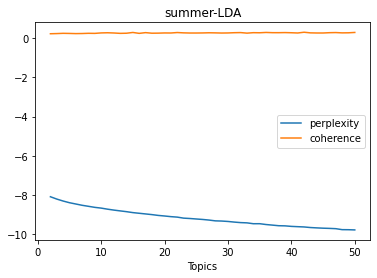

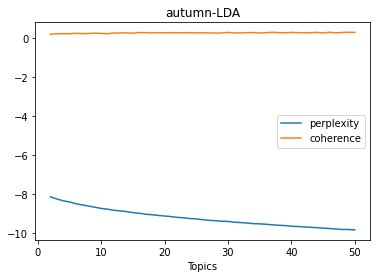

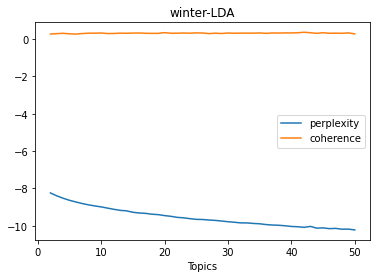

In [70]:
# Plot results
for key, _ in data_words_list.items():
    perplexity_result, coherence_result
    x = list(range(min_topic,max_topic+1))
    plt.plot(x,list(perplexity_result[key].values()), label = "perplexity")
    plt.plot(x,list(coherence_result[key].values()), label = "coherence")
    plt.xlabel("Topics")
    plt.legend()
    plt.title(f"{key}-LDA")
    plt.show()

In [71]:
# lda_result=load("season_lda")

In [72]:
topic_num = 8
max_doc = 20
# Display tweets for each topic
for key, _ in data_words_list.items():
    print(key)
    for topic_idx, values in lda_result[key][topic_num].show_topics(formatted=False,num_topics=topic_num, num_words=5):
        results = ", ".join(i[0] for i in values)
        print(f"Topic {topic_idx}: {results}")
    print()

spring
Topic 0: store, grocery, go, people, stay
Topic 1: food, people, panic, lockdown, waste
Topic 2: price, oil, low, consumer, economy
Topic 3: supermarket, store, crash, ju, teeter
Topic 4: food, consumer, demand, dog, say
Topic 5: supermarket, price, wealth, norwegian, slum
Topic 6: prior, batch, sovereign, price, today
Topic 7: price, chain, coffee, food, supply

summer
Topic 0: price, supermarket, store, due, say
Topic 1: supermarket, people, grocery, store, shopping
Topic 2: price, food, supermarket, worker, pandemic
Topic 3: food, price, grocery, store, market
Topic 4: price, essential, hand, sanitizer, people
Topic 5: food, consumer, demand, price, store
Topic 6: price, go, shopping, supermarket, online
Topic 7: grocery, store, supermarket, price, shopping

autumn
Topic 0: store, grocery, sanitizer, price, get
Topic 1: grocery, store, shopping, online, consumer
Topic 2: consumer, price, crisis, pandemic, take
Topic 3: hand, store, sanitizer, food, price
Topic 4: consumer, pa

In [73]:
# Display tweets for each topic
for key, data_words in data_words_list.items():
    print(f"============================{key}: Top tweets in Topics ============================")
    id2word, data_words, corpus = preprocess_LDA(data_words)
    topic_top_tweets = get_top_tweets(lda_result[key][topic_num], corpus, topic_num, max_doc)
    for i in range(topic_num):
        print(f"Topic {i}")
        pprint(display_text_LDA(topic_top_tweets,i))
        print()

============================spring: Top tweets in Topics ============================
Topic 0
array(['CLOSED: Summit County people, businesses preparing for UtahÂ\x92s first stay at home order. Grocery store managers telling me the stores are packed. Lunds Art Sculpture Gifts is closed. While this is tough on business, the owner says he supports this decision. #coronavirus https://t.co/J6hz8omt7R',
       'Update from when I went to the grocery store at 6am: meat is nearly gone, I was able to snag a roll of toilet paper, we took the last bread, stocked up on frozen veggies, &amp; my school STILL hasnÂ\x92t extended spring break. \r\r\n\r\r\nEveryone really is out here wildin. Stay safe #COVID2019',
       '#coronavirus just went to grocery store sad to see the lack of common courtesy people have when buying the shelves empty. Was looking at the butter and a little old lady was trying to reach a pack of butter I brought it down for her and she whispered I just want to make cookies.',
  

#### NMF

In [74]:
perplexity_list = dict()
topic_results_list = dict()
topic_tweets_list = dict()

# Run NMF
for key, data_words in data_words_list.items():
    print(key)
    topic_results, topic_tweets_results, perplexity_results = apply_NMF(data_words, min_topic,max_topic, top_words = top_word)
    perplexity_list[key] = perplexity_results
    topic_results_list[key] = topic_results
    topic_tweets_list[key] = topic_tweets_results

# save(topic_results_list, "season_topic_results_nmf")
# save(topic_tweets_list, "season_topic_tweets_nmf")

spring
Topic: 2      Perplexity: 1.0352649238413776
Topic: 3      Perplexity: 1.0253847998347718
Topic: 4      Perplexity: 1.199555576040902
Topic: 5      Perplexity: 1.1119746535628108
Topic: 6      Perplexity: 1.1974059064425122
Topic: 7      Perplexity: 1.1214756638917986
Topic: 8      Perplexity: 1.1425995629403416
Topic: 9      Perplexity: 1.0784905419538793
Topic: 10      Perplexity: 1.079761234088018
Topic: 11      Perplexity: 1.1149938730349975
Topic: 12      Perplexity: 1.1179472645636102
Topic: 13      Perplexity: 1.0765401336803064
Topic: 14      Perplexity: 1.1089391960738826
Topic: 15      Perplexity: 1.0939971328806846
Topic: 16      Perplexity: 1.087042961831381
Topic: 17      Perplexity: 1.1075086859410919


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic: 18      Perplexity: 1.079471742021466
Topic: 19      Perplexity: 1.1059564773642712
Topic: 20      Perplexity: 1.100428258147489
Topic: 21      Perplexity: 1.0923899028075121
Topic: 22      Perplexity: 1.070685379500885
Topic: 23      Perplexity: 1.0829215480346002
Topic: 24      Perplexity: 1.067610982033283


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic: 25      Perplexity: 1.071680115770136
Topic: 26      Perplexity: 1.0296578353276458
Topic: 27      Perplexity: 1.0503249449696077
Topic: 28      Perplexity: 1.0679642346625244
Topic: 29      Perplexity: 1.0682340252224258
Topic: 30      Perplexity: 1.0716361758581991
Topic: 31      Perplexity: 1.070208903451846
Topic: 32      Perplexity: 1.0564002033819553
Topic: 33      Perplexity: 1.073713815544178
Topic: 34      Perplexity: 1.0637779511346162
Topic: 35      Perplexity: 1.0476173069635892
Topic: 36      Perplexity: 1.0543555081457843
Topic: 37      Perplexity: 1.0354295184991558
Topic: 38      Perplexity: 1.041169104598771
Topic: 39      Perplexity: 1.049368737291718
Topic: 40      Perplexity: 1.0570858456916754
Topic: 41      Perplexity: 1.051947883046999
Topic: 42      Perplexity: 1.0529599601291
Topic: 43      Perplexity: 1.046123163665872
Topic: 44      Perplexity: 1.0488615890938924
Topic: 45      Perplexity: 1.035740718505746
Topic: 46      Perplexity: 1.034546495258885


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic: 26      Perplexity: 1.0896586000880977
Topic: 27      Perplexity: 1.070865321006461
Topic: 28      Perplexity: 1.0493998212530173
Topic: 29      Perplexity: 1.0698423144037914
Topic: 30      Perplexity: 1.0776552579198753
Topic: 31      Perplexity: 1.0529024533774982
Topic: 32      Perplexity: 1.076316198334584
Topic: 33      Perplexity: 1.0701865236247128
Topic: 34      Perplexity: 1.0675144110609425
Topic: 35      Perplexity: 1.0556741597171428
Topic: 36      Perplexity: 1.0498654970331176
Topic: 37      Perplexity: 1.0457902366629561
Topic: 38      Perplexity: 1.0680809498001287
Topic: 39      Perplexity: 1.0591958652235511
Topic: 40      Perplexity: 1.0583286611681637
Topic: 41      Perplexity: 1.043246736011689
Topic: 42      Perplexity: 1.0474260029615605
Topic: 43      Perplexity: 1.0488552838972018
Topic: 44      Perplexity: 1.049524215595165
Topic: 45      Perplexity: 1.0463193122142709


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic: 46      Perplexity: 1.04774247885807
Topic: 47      Perplexity: 1.0522289413187969
Topic: 48      Perplexity: 1.0470430076492394
Topic: 49      Perplexity: 1.0552110413633644
Topic: 50      Perplexity: 1.0422041921990606
autumn
Topic: 2      Perplexity: 1.0905077326652577
Topic: 3      Perplexity: 1.110784505790769
Topic: 4      Perplexity: 1.0944362860786794
Topic: 5      Perplexity: 1.158447616990828
Topic: 6      Perplexity: 1.2183361930090653
Topic: 7      Perplexity: 1.0937318425363876
Topic: 8      Perplexity: 1.098464274382643
Topic: 9      Perplexity: 1.0798283610739083
Topic: 10      Perplexity: 1.1325777981355722
Topic: 11      Perplexity: 1.150600541931277
Topic: 12      Perplexity: 1.0850559433535343
Topic: 13      Perplexity: 1.1263251420033884
Topic: 14      Perplexity: 1.1083288507736186
Topic: 15      Perplexity: 1.1203125915865682
Topic: 16      Perplexity: 1.0581476625224868
Topic: 17      Perplexity: 1.1067820614068717
Topic: 18      Perplexity: 1.105300955166

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic: 18      Perplexity: 1.0473335455559685
Topic: 19      Perplexity: 1.0965895661580294
Topic: 20      Perplexity: 1.03351669592085
Topic: 21      Perplexity: 1.0841019832402163
Topic: 22      Perplexity: 1.0341193013613512
Topic: 23      Perplexity: 1.0590359104121638
Topic: 24      Perplexity: 1.0832498439576763
Topic: 25      Perplexity: 1.0829569064705913
Topic: 26      Perplexity: 1.0414013195674512
Topic: 27      Perplexity: 1.0769287997307821
Topic: 28      Perplexity: 1.068525674868046
Topic: 29      Perplexity: 1.05003390402769
Topic: 30      Perplexity: 1.0633926196663532
Topic: 31      Perplexity: 1.0467999796653358
Topic: 32      Perplexity: 1.0594687037308752
Topic: 33      Perplexity: 1.0605315085579985
Topic: 34      Perplexity: 1.0637676834626715
Topic: 35      Perplexity: 1.0352583857380777
Topic: 36      Perplexity: 1.047125762578226
Topic: 37      Perplexity: 1.054400478919476
Topic: 38      Perplexity: 1.0398964565525861
Topic: 39      Perplexity: 1.057028061796

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Topic: 46      Perplexity: 1.050646361312978
Topic: 47      Perplexity: 1.0433002475701751
Topic: 48      Perplexity: 1.035462775477104
Topic: 49      Perplexity: 1.0527866176449492
Topic: 50      Perplexity: 1.0393693005127678


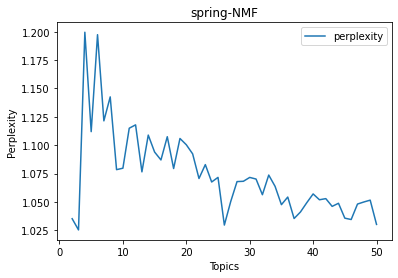

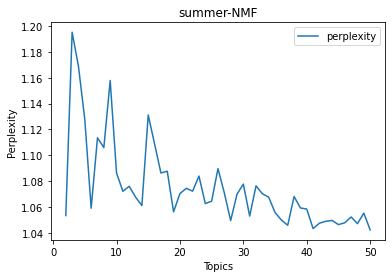

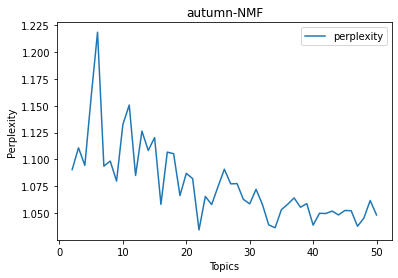

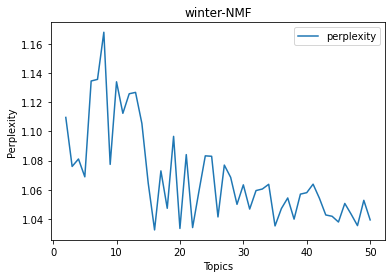

In [75]:
# Plot results
for key, data_words in data_words_list.items():
    x = list(range(min_topic, max_topic+1))
    plt.plot(x,list(perplexity_list[key].values()), label = "perplexity")
    plt.xlabel("Topics")
    plt.ylabel("Perplexity")
    plt.title(f"{key}-NMF")
    plt.legend()
    plt.show()

In [76]:
# topic_results_list=load("season_topic_results_nmf")
# topic_tweets_list=load("season_topic_tweets_nmf")

In [77]:
topic_num = 6
# Display topic words
for key, data_words in data_words_list.items():
    print(key)
    for key, value in topic_results_list[key][topic_num].items():
        print(f"topic {key}: ", ", ".join(value))

spring
topic 0:  store, grocery, worker, work, retail, employee, close, time, thank, get, line, hour, open, say, day, pandemic, essential, go, home, make
topic 1:  food, panic, stock, buy, supply, demand, need, buying, bank, help, get, say, due, increase, shortage, stop, chain, enough, shelf, pandemic
topic 2:  price, oil, low, market, increase, gas, demand, pandemic, fall, due, high, drop, time, hand, mask, take, sanitizer, sell, see, say
topic 3:  supermarket, worker, shelf, work, staff, get, local, empty, time, delivery, shop, day, see, thank, keep, need, hour, home, social, week
topic 4:  consumer, online, shopping, business, pandemic, help, impact, time, change, new, home, good, crisis, behavior, due, report, shop, demand, make, service
topic 5:  people, go, get, buy, need, online, hand, home, shop, shopping, sanitizer, make, stay, think, work, panic, time, stop, see, thing
summer
topic 0:  store, grocery, go, worker, mask, employee, work, wear, day, say, get, die, line, retail, e

In [78]:
# Display tweets
for key, data_words in data_words_list.items():
    print(key)
    for i in range(topic_num):
        print(f"Topic {i}")
        pprint(display_text_NMF(topic_tweets_list[key][topic_num], i, max_doc=20))
        print()

spring
Topic 0
array(['I know a lot of grocery stores are low on stock of some items. If you need something right away, try the Dollar Store, bodegas, 7-11, drug stores or ask friends/neighbors. I found some things the grocery store was sold out of at the Dollar Store yesterday. #coronavirus',
       'If you can use an app and pick-up at the grocery store that is best. If the grocery stores are not app capable they should have someone in the vestibule, possibly closing the store, to take orders for people to eliminate contact and contamination of the store. #coronavirus #Covid',
       "Sick people - Please STOP going to the grocery store! Order delivery! It's called self isolation! I'm tired of seeing people with coronavirus at the grocery store. Restaurants are more sanitary than the grocery stores! I'm ordering take-out, it's safer! #coronavirus",
       '#Ohiolockdown\r\r\n\r\r\nGrocery stores are not closing. STOP Hoarding.\r\r\nGrocery stores are not closing. STOP Hoarding.\r\r\n

#### BTM

In [79]:
perplexity_result, coherence_result, btm_result, phi_result = dict(),dict(),dict(), dict()
# Run BTM
for key, data_words in data_words_list.items():
    print(f"============================{key} Start BTM ============================")

    perplexity, coherence, model, phi= apply_BTM(data_words,min_topic,max_topic)
    perplexity_result[key] = perplexity
    coherence_result[key] = coherence
    btm_result[key] = model
    phi_result[key] = phi

# save(btm_result,"season_btm")
# save(phi_result,"season_btm_phi")

============================spring Start BTM ============================
Topic 2 Done: Perplexity: 3.951315432990287e+171  Coherence Score: -114.27183416294082


/usr/local/lib/python3.7/dist-packages/tmplot/_helpers.py:39: UserWarning: Please install "tomotopy" package to analyze its models.
Run `pip install tomotopy` in the console.
  f'Please install "{package_name}" package to analyze its models.\n'


Topic 3 Done: Perplexity: 1.6520971013345857e+287  Coherence Score: -112.38596809768917
Topic 4 Done: Perplexity: 9.894909318619747e+290  Coherence Score: -113.10109216629701
Topic 5 Done: Perplexity: 1.131432879852796e+306  Coherence Score: -111.17673683058926
Topic 6 Done: Perplexity: 1.0  Coherence Score: -115.32926344345589
Topic 7 Done: Perplexity: 7.587108753931894e+226  Coherence Score: -110.73583017862809
Topic 8 Done: Perplexity: 1.0  Coherence Score: -108.742700969587
Topic 9 Done: Perplexity: 1.157408699834497e+99  Coherence Score: -106.69217183880788
Topic 10 Done: Perplexity: 2.1409375796017356e+206  Coherence Score: -108.6500968598586
Topic 11 Done: Perplexity: 6.838414731491569e+286  Coherence Score: -113.76544260464101
Topic 12 Done: Perplexity: inf  Coherence Score: -110.47410755698006
Topic 13 Done: Perplexity: inf  Coherence Score: -116.43696957335918
Topic 14 Done: Perplexity: inf  Coherence Score: -115.59504958889599
Topic 15 Done: Perplexity: 298.2557652706495  Co

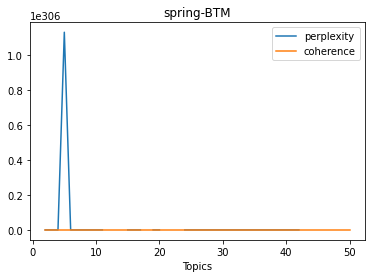

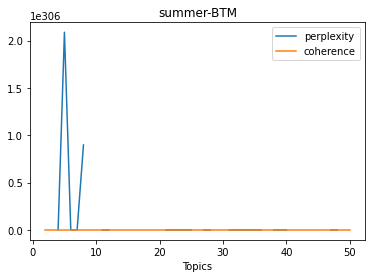

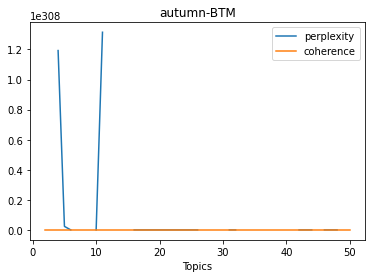

In [80]:
# Plot results
for key, _ in data_words_list.items():
    perplexity_result, coherence_result
    x = list(range(min_topic,max_topic+1))
    plt.plot(x,list(perplexity_result[key].values()), label = "perplexity")
    plt.plot(x,list(coherence_result[key].values()), label = "coherence")
    plt.xlabel("Topics")
    plt.legend()
    plt.title(f"{key}-BTM")
    plt.show()

In [81]:
# btm_result=load("season_btm")
# phi_result=load("season_btm_phi")

In [82]:
topic_num = 6
# Display topic words
for key, _ in data_words_list.items():
    print(key)
    display_BTM(phi_result[key][topic_num])

spring
Topic 0: consumer, online, price, help, business
Topic 1: store, grocery, supermarket, food, people
Topic 2: store, supermarket, grocery, people, go
Topic 3: food, store, supermarket, people, go
Topic 4: food, go, hand, supermarket, people
Topic 5: price, consumer, oil, demand, food
summer
Topic 0: price, hand, sanitizer, people, food
Topic 1: store, grocery, supermarket, go, worker
Topic 2: food, online, shopping, store, price
Topic 3: price, food, supermarket, go, store
Topic 4: price, oil, consumer, pandemic, demand
Topic 5: food, price, online, help, time
autumn
Topic 0: food, online, store, supermarket, help
Topic 1: consumer, price, business, change, help
Topic 2: price, oil, demand, market, pandemic
Topic 3: store, grocery, hand, worker, sanitizer
Topic 4: consumer, price, pandemic, new, behavior
Topic 5: store, grocery, supermarket, go, worker
winter
Topic 0: supermarket, store, people, online, get
Topic 1: hand, sanitizer, store, mask, grocery
Topic 2: consumer, price, 

In [83]:
# Display tweets
for key, data_words in data_words_list.items():
    print(f"============================{key} Top tweets in topic ============================")
    display(display_text_BTM(btm_result[key][topic_num], data_words))


============================spring Top tweets in topic ============================


topic0  \
0   midday today port melbourne cole can food aisl...   
1   social distancing diary day sunburnt tired los...   
2   freedom grant take simple thing chilling frien...   
3   learn quarantinestorie humanity homeless chari...   
4   price petfood week time name shame retailer pu...   
5   oilpricewar oil price rise hope price war truc...   
6   put therelike ellensstardust supermarket store...   
7   online make sure line long line supermarket se...   
8   update follow home visit cancel foreseeable fu...   
9   glad say panic buy food stockpile book accepta...   
10                                                      
11  hear supermarket clearly compare coldâ messag...   
12  religious go supermarket find child child clea...   
13  authority launch investigation increase price ...   
14  minute video prepare hand sanitizer minute cor...   
15  consider citizen say somizi testing price coro...   
16  get back walk local supermarket family nearly ...   
17        elderly londoner speak panic buying fuckwit   
18  pandemic force consumer even shop online behavior   
19    hypocrite price hike soap sanitizer people need   

                                               topic1  \
0   âmedia focus individual take advantage market...   
1   scam identity thief hard work get personal inf...   
2   ridiculous supermarket hull morning absolutely...   
3   gas price dollar still price oil drop third al...   
4   imagine real estate asset price come due downp...   
5   local grocery store hour early open time senio...   
6   anxious shopper snatch gun potential chaos rel...   
7                                        meanwhile nz   
8   lesson resilience food system important deal f...   
9   useloom time take action response cut price re...   
10  bottle hand sanitizer make local distillery to...   
11        much hazard pay grocery store employee make   
12  crazy currently stick home confirm try book fo...   
13          shop limit itâ online sale free shipping   
14  allow resell item clear supermarket inflate pr...   
15  want take minute send special thank work front...   
16  world enough need enough harsh lockdown people...   
17  almena resident say stressful watch people sto...   
18  grocery store toilet paper egg survive run cof...   
19  today give relevant insight base daily trackin...   

                                               topic2  \
0   make big feast rid zombie virus panic stay awa...   
1   go buy grocery hike price line long expect wel...   
2   supermarket shelf still strip essential item i...   
3   uptick online fraud phishing attack relate dil...   
4   price slip back asian vote massive stimulus pa...   
5   email notice business action economic recovery...   
6   fact go supermarket buffooninoffice arrive min...   
7   probably advertise see people toilet paper loo...   
8   due global impact retail showroom hudson close...   
9   able get need youâre try get grocery shopping...   
10  consumer confidence slip sharply due restricti...   
11  low gas price expert say gas hit cent state du...   
12  still seller allow sell platform inflate price...   
13  asda linwood still open shut stockpile stoppan...   
14  getz manufacturer stock order new raw material...   
15  real issue reveal govmnt try boost demand serv...   
16  midday today port melbourne cole can food aisl...   
17                price son confirm get symptomshttps   
18  virus crisis drive demand launch first virtual...   
19  order shelter place order say people go bank p...   

                                               topic3  \
0   police curfew lift hour colombo run supermarke...   
1   read perspective baby boomer push make first r...   
2   irishman other happystpatricksdayat least buy ...   
3   affect supplychain food supplier retailer stru...   
4   possible buy thing supermarket support local s...   
5   check video food market due panic go die starv...   
6       gavinnewsom pos gas price fall pricegouge oil 

============================summer Top tweets in topic ============================


topic0  \
0   good part pre speech tonight acknowledge badly...   
1   oil price massive cut oil production follow me...   
2   website buy register passport drive license af...   
3   patrol park supermarket car park today include...   
4   stick home online get free donation shopsign g...   
5   term socialdistancing first enter lexicon week...   
6   totally understand severe physical health prob...   
7                  probably chill average familyhttps   
8   shopper warn wear glove supermarket coronaviru...   
9   order premium return consumer business affect ...   
10  food rescue group busy keep high demand outbre...   
11  meet ceo major energy company discuss fall pri...   
12  buy frozen veggie limit trip grocery storenow ...   
13  founder say base business never see demand onl...   
14  implement negotiate reduce internet price pand...   
15  scammer take advantage fear anxiety surround q...   
16  safety practice supermarket provide safe place...   
17  synthesis income relate finding recommendation...   
18  walk supermarket today many ppl various type m...   
19             favorite emergency food gain new fan u   

                                               topic1  \
0   take kid grocery store today absolute necessit...   
1   trump recommend people take drug prophylactic ...   
2   test complete confirm case death key concern t...   
3   picture trip local grocery store dead land des...   
4   thing â know single parent â check perhaps g...   
5   cut benchmark interest rate extend consumer lo...   
6                      tell people use hand sanitizer   
7   order premium return consumer business affect ...   
8   stuck home smell hand sanitizer create toomuch...   
9   supermarket staff member test positive shopper...   
10  see much percent percent increase demand indiv...   
11  dairy farmer affect milk price cut supermarket...   
12  empty shelf supermarket conclude isolation peo...   
13  atomic robot comic_strip toy reduce price noti...   
14  realise vulnerable people online shopping acco...   
15  think easy option walking dog perhaps alone dr...   
16  man accuse sneeze cough people christchurch su...   
17  people keep say show important people society ...   
18  normal problem worker deserve decent secure we...   
19  share profit low crude oil price people pandem...   

                                               topic2  \
0   petrol diesel rate stagnant lockdown oil price...   
1   cannalogue introduce inclusive compassionate c...   
2   faith butcher member marketing team explore im...   
3   demand food service worker receive full pay he...   
4   matter live good chance community hungry many ...   
5               deal close oil price likely stabilize   
6   naivas supermarket award kind hearted police o...   
7   guy itâ clear stay home afraid get fresh air ...   
8   order premium return consumer business affect ...   
9   try try keep sell crisis learn convince custom...   
10  think easy option walking dog perhaps alone dr...   
11  speculation uncertainty total australian red m...   
12         add retail signage help store deal concern   
13             favorite emergency food gain new fan u   
14  mission time store close pandemic help safely ...   
15  part jimmy quiroga r design virtual motherâ d...   
16  wh say limit trip grocery store pharmacy week ...   
17  launch essential service let customer order vi...   
18  realdonaldtrump get big deal test impressive c...   
19  day trump refuse use full power defense produc...   

                                               topic3  \
0   look people shop empty food shelf supermarket ...   
1   last month governor step protect state lot fed...   
2             easyjet dream go supermarket find pasta   
3   nobodyâ case crude oil regain enormous loss i...   
4               crude oil soar producer agree indilen   
5   make senior especially vulnerable serious infe...   
6   odd go supermarket buy usual food supply satur... 

============================autumn Top tweets in topic ============================


topic0  \
0   state shut yet chance die well chance die car ...   
1   people friend family help shop management fina...   
2   claim case death however cupboard bare select ...   
3   hand sanitizer rivercityom rcom doctor medical...   
4   worldwide problem work male russiaread report ...   
5   note webinar week broadcast network shortage n...   
6                             always lead front canon   
7   key point understand even rural household grow...   
8   straight outta hand sanitizer fly shelf winery...   
9   daily mail grocery store clerk die continued w...   
10  evolve problem economy go many year rise real ...   
11  stay safe keep pocket sanitizer pocket rub han...   
12  opinion win team include big boom design remot...   
13                                                      
14  get cold air condition room notice easy get su...   
15  university index consumer sentiment report lar...   
16  global consumer concern healthyeate comforteat...   
17  grocery store worker die consider brave people...   
18                                           consumer   
19  issue stand line least foot apart grocery stor...   

                                               topic1  \
0   construction crew limit size work close proxim...   
1   food plant worker die test positive retail who...   
2   survive die alcoholism happen eat entire groce...   
3   fuelupdate petrol diesel price static successi...   
4   grocery store alert quã bec find sick handling...   
5   grocery contest alert giveawayalert competitio...   
6   restaurant turn grocery store help community r...   
7                                datum increase price   
8   read tip share encourage protect personal fina...   
9   base grocery store homeland make change policy...   
10  yellow black red whitechoose permaroute follow...   
11  deliver delicious dinner well brisket hand san...   
12  business plan considerable focus consumer prot...   
13        local supermarket practice socialdistancing   
14  jot thought cocoon day apartment beach field f...   
15  rice wheat price surge fear lockdown threaten ...   
16  kdka radio morning sponsor giant eagle superma...   
17  think possible stop buy country individual con...   
18  insight search datum think data reveal brand h...   
19  iri market analytic firm specialize consumer t...   

                                               topic2  \
0   change global supply chain consumer sentiment ...   
1   essential view retailer respond pandemic retai...   
2   impact consumer mobile app use time spend past...   
3             ask bioethicist online grocery shopping   
4   make way people empty store buy weird thing ti...   
5   seem today datum sign post election bounce gro...   
6   minute alarm disruption economic activity spar...   
7   danawhite come event safe staying home go groc...   
8   south store long weekend hour enjoy long weeke...   
9     deal recent turbulence experience emerge market   
10  umich consumer sentiment index show record mon...   
11                                consumer retaildive   
12  ask consumer never ever watch response find so...   
13  learn do dont protect other different realisti...   
14  get supermarket socialdistancing pretty much p...   
15  facial mask sale surround competitive price in...   
16  learn employee retail sale store ââ test posi...   
17  day undefined update approve essential online ...   
18  big thank bill involve sbjunpack podcast discu...   
19  grocery contest alert giveawayalert competitio...   

                                               topic3  \
0   list nz retirement stock share price dive happ...   
1   big story wash worker death today news abtdeat...   
2            outlive corona consumer research suggest   
3   hope teach stop judge people base job title ea...   
4   warning come back week schedule âdangerous ri...   
5   rest peace run ravitzmarket operate shopritest...   
6   good part people wear glove use phone grocery ... 

============================winter Top tweets in topic ============================


topic0  \
0   take time shop space buying even add essential...   
1   much love student loan debt wipe away point co...   
2   linger air long previously think scientist war...   
3   emily myth need debunk front line right bus dr...   
4   wear mask thing itâ considerate make clear ca...   
5   lower octane petrol price bid mitigate impact ...   
6   food supply chain strong pandemic keep way str...   
7   fight b long mnfctring unit keep close long ti...   
8   big question mind journalism survive mean whol...   
9   happy rise occasion food bank try meet demand ...   
10  dress allow supermarket socialdistancing goesi...   
11  effect consumer behavior video content savvy a...   
12              pay attention scared get package food   
13  grocery store worker currently high exposure h...   
14  online food shopping late herehttps onlineshop...   
15  pollen spring rva sneeze time grocery store pa...   
16  homedepot horrible job stop spread socialdista...   
17  wholesale food business ship directly consumer...   
18  last buy antibacterial hand sanitizer cole gol...   
19       inspire local hero ongoing series nknzihenvt   

                                               topic1  \
0   take time shop space buying even add essential...   
1   fight b long mnfctring unit keep close long ti...   
2   much love student loan debt wipe away point co...   
3   emily myth need debunk front line right bus dr...   
4   wear mask thing itâ considerate make clear ca...   
5   lower octane petrol price bid mitigate impact ...   
6   food supply chain strong pandemic keep way str...   
7   linger air long previously think scientist war...   
8   happy rise occasion food bank try meet demand ...   
9   big question mind journalism survive mean whol...   
10  pollen spring rva sneeze time grocery store pa...   
11  online food shopping late herehttps onlineshop...   
12              pay attention scared get package food   
13  grocery store worker currently high exposure h...   
14  effect consumer behavior video content savvy a...   
15  homedepot horrible job stop spread socialdista...   
16  mysteriousuniv lookner food bank overrun surge...   
17  dress allow supermarket socialdistancing goesi...   
18  affordable realestate chinatown supermarket ac...   
19  wholesale food business ship directly consumer...   

                                               topic2  \
0   take time shop space buying even add essential...   
1   emily myth need debunk front line right bus dr...   
2   food supply chain strong pandemic keep way str...   
3   fight b long mnfctring unit keep close long ti...   
4   much love student loan debt wipe away point co...   
5   wear mask thing itâ considerate make clear ca...   
6   lower octane petrol price bid mitigate impact ...   
7   linger air long previously think scientist war...   
8   happy rise occasion food bank try meet demand ...   
9   big question mind journalism survive mean whol...   
10  go convenient essential coronaviruspandemic co...   
11  mysteriousuniv lookner food bank overrun surge...   
12  homedepot horrible job stop spread socialdista...   
13              pay attention scared get package food   
14  grocery store worker currently high exposure h...   
15  dress allow supermarket socialdistancing goesi...   
16  effect consumer behavior video content savvy a...   
17  online food shopping late herehttps onlineshop...   
18  pollen spring rva sneeze time grocery store pa...   
19  affordable realestate chinatown supermarket ac...   

                                               topic3  \
0   fight b long mnfctring unit keep close long ti...   
1   much love student loan debt wipe away point co...   
2   wear mask thing itâ considerate make clear ca...   
3   food supply chain strong pandemic keep way str...   
4   linger air long previously think scientist war...   
5   take time shop space buying even add essential...   
6   lower octane petrol price bid mitigate impact ... 

#### CorEx

In [84]:
corex_result = dict()
tc_result = dict()
# Run corex with anchor words "oil"
for key, data_words in data_words_list.items():
    print(f"============================{key} Start CorEx ============================")

    tc, corex_models = apply_Corex(data_words, min_topic, max_topic,anchor_words=["oil"])
    corex_result[key] = corex_models
    tc_result[key] = tc

# save(corex_result, "season_corex")

============================spring Start CorEx ============================
Topic 2 Total Covraiance: 0.6869106103258884
Topic 3 Total Covraiance: 0.653612662541263
Topic 4 Total Covraiance: 0.7529938917603443
Topic 5 Total Covraiance: 0.9175323980164527
Topic 6 Total Covraiance: 0.8113782688839473
Topic 7 Total Covraiance: 0.9215268061795141
Topic 8 Total Covraiance: 0.9202414773691139
Topic 9 Total Covraiance: 0.7993924457460703
Topic 10 Total Covraiance: 0.9485285530770848
Topic 11 Total Covraiance: 1.121501149985972
Topic 12 Total Covraiance: 1.1384074180090449
Topic 13 Total Covraiance: 0.9236049553483748
Topic 14 Total Covraiance: 1.0341352443780223
Topic 15 Total Covraiance: 1.0771952533157678
Topic 16 Total Covraiance: 0.8760249872633712
Topic 17 Total Covraiance: 1.018326422196439
Topic 18 Total Covraiance: 1.1881566206691108
Topic 19 Total Covraiance: 0.9714646181253823
Topic 20 Total Covraiance: 1.2187953822591957
Topic 21 Total Covraiance: 1.1825107851073415
Topic 22 Total 

In [85]:
# save(tc_result, "season_tc")

In [86]:
# tc_result= load("season_tc")
# corex_result= load("season_corex")

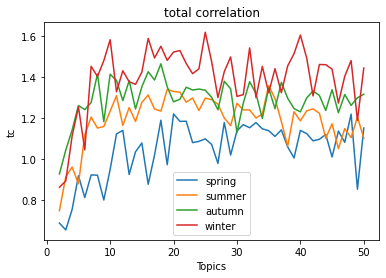

In [87]:
# Plot results
x = list(range(min_topic,max_topic+1))
for key, _ in data_words_list.items():
    plt.plot(x,list(tc_result[key].values()), label = key)
    # print(key)
plt.legend()
plt.title("total correlation")
plt.xlabel("Topics")
plt.ylabel("tc")
plt.show()

In [88]:
topic_num = 12
# Display topic words
for key, _ in data_words_list.items():
    print(key)
    topics = corex_result[key][topic_num].get_topics()
    display_corex(topics)


spring
Topic 0: store, grocery, ~price, retail, ~consumer
Topic 1: health, public, emergency, state, government
Topic 2: help, support, small, vulnerable, business
Topic 3: people, think, bad, know, need
Topic 4: social, distancing, follow, post, measure
Topic 5: online, shopping, shop, order, deliver
Topic 6: demand, ~supermarket, increase, impact, pandemic
Topic 7: sanitizer, hand, mask, glove, use
Topic 8: panic, food, buy, buying, stock
Topic 9: toilet, paper, roll, toiletpaper, find
Topic 10: worker, home, work, stay, driver
Topic 11: go, get, week, last, day
summer
Topic 0: price, oil, ~supermarket, low, ~consumer
Topic 1: mask, wear, glove, face, stop
Topic 2: go, week, last, back, thing
Topic 3: stay, home, safe, delivery, keep
Topic 4: hand, sanitizer, use, clean, fight
Topic 5: test, happen, positive, itâ, shelf
Topic 6: toiletpaper, paper, ~company, ~many, toilet
Topic 7: store, grocery, worker, retail, employee
Topic 8: socialdistancing, line, try, ~state, ~economy
Topic 9:

In [90]:
# Display tweets
for key, data_words in data_words_list.items():
    print(f"============================{key} Top tweets in topics ============================")
    for i in range(topic_num):
        print(f"Topic {i}")
        pprint(display_text_corex(corex_result[key][topic_num], i, max_doc=10))
        print()

============================spring Top tweets in topics ============================
Topic 0
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
array(['While I fully support healthcare professionals on the front lines of the #covid19 #Coronavirus #pandemic Can we shout out to everyone who still has to work! Retail/grocery store employees, utility technicians, truck drivers, government, military, police and so on. Thank them all!',
       'We wanted to take a moment to thank all of those working on the front lines to combat COVID-19. Healthcare workers, those in manufacturing and transportation, retail and grocery store employees, scientists, and everyone working from home to flatten the curve: THANK YOU. https://t.co/crCVrL9CQI',
       'Thank you, to all the officials, who are acting like adults, and working on the Wuhan Flu. Thank you Medical Personal, standing by and ready. But a huge thank you, to retail grocery store employees. They are the heros of the